In [3]:
# %%
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as kb
import tensorflow as tf
from sklearn.preprocessing import PolynomialFeatures
import scipy.io as scio
import timeit
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import normalized_root_mse as NRMSE
fid=0
physical_devices = tf.config.list_physical_devices()
for dev in physical_devices:
    print(dev)



PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
# %%
keras.saving.get_custom_objects().clear()
print(tf.__version__)


2.13.1


In [5]:
# %%
trainmodel=False
filebase='./saved_model/forward_model/'
data_path='./training_data'
data_mat=scio.loadmat((os.path.join(data_path, "data64X64(75-125mm)(393-503K)ln1+gs1.mat")))
input_data=data_mat['input']
out_data=data_mat['output']
print(input_data.shape,out_data.shape)


(4752, 4) (4752, 64, 64, 3)


In [6]:
# %%

class DLTrainer():
    def __init__(self, dlmodel, filebase=None,monitor='loss',load_exist_model=True,b_checkpoint=False, batch_size=128, patience_lr=500, min_delta=1e-5):
        self.checkpoint_fname = None
        checkpoint = []
        self.filebase = filebase
        if self.filebase != None:
            if self.filebase[-1] != '/':
                self.filebase += '/'
            try:
                os.makedirs(self.filebase)
            except OSError as error:
                print(error)
        self.batch_size = batch_size

        self.checkpoint_fname = self.filebase+'weights/checkpoint'
        checkpoint = ModelCheckpoint(self.checkpoint_fname,
                                     save_weights_only=True,
                                     monitor=monitor,
                                     verbose=1,
                                     save_freq='epoch',
                                     save_best_only=True,
                                     mode='min')

        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                         factor=0.5, patience=patience_lr,
                                                         verbose=1, mode='auto',
                                                         min_delta=min_delta, cooldown=0, min_lr=1e-8)
        EarlyStop = tf.keras.callbacks.EarlyStopping(
            monitor='loss', min_delta=min_delta, patience=int(patience_lr*2))
        if b_checkpoint:
            self.callback_lists = [reduce_lr,
                                EarlyStop, checkpoint]
        else:
            self.callback_lists = [reduce_lr,EarlyStop]

        if os.path.isfile(self.filebase+'saved_model.keras') and load_exist_model:
            self.DLModel=tf.keras.models.load_model(self.filebase+'saved_model.keras',compile=False)
            print('Load the saved model!')
        else:
            self.DLModel = dlmodel
            print("set model!")
        try:
            self.DLModel.summary()
        except OSError as error:    
            print(error)
        tf.keras.utils.plot_model(self.DLModel, 
                                  to_file=self.filebase+'model_graph.png',
                                  show_shapes=True,show_layer_activations=True)
    def loadModel(self, checkpoint_fname):
        self.DLModel.load_weights(checkpoint_fname)

    def self_loadModel(self):
        self.DLModel.load_weights(self.checkpoint_fname)

    def setLearningRate(self, lr=1e-3):
        kb.set_value(self.DLModel.optimizer.lr, lr)

    def train_DLmodel(self, input, target=None, lr=None, numEpochs=300,validation_data=None):
        start_time = timeit.default_timer()
        if os.path.isfile(self.checkpoint_fname):
            self.DLModel.load_weights(self.checkpoint_fname)
        if lr is not None:
            kb.set_value(self.DLModel.optimizer.lr, lr)
        h = self.DLModel.fit(input, target,
                                batch_size=self.batch_size, epochs=numEpochs,
                                verbose=2,
                                callbacks=self.callback_lists,validation_data=validation_data)  #

        stop_time = timeit.default_timer()
        print('\n \n')
        print('training Run time so far: ', round(
            stop_time - start_time, 2), '(s)')
        if os.path.isfile(self.filebase+'losses.csv'):
            df_history = pd.read_csv(self.filebase+'losses.csv', index_col=0)
            df_history_total = {key: df_history[key].tolist(
            ) + (h.history)[key] for key in h.history}

        else:
            df_history_total = h.history
        df_history_total = pd.DataFrame(df_history_total)
        df_history_total.to_csv(self.filebase+'losses.csv')
        if os.path.isfile(self.checkpoint_fname):
            self.self_loadModel()
        try:
            self.DLModel.save(self.filebase+'saved_model.keras')
        except:
            print('Can not save model!')
        return df_history_total

    def predict(self, input_test):
        vf_pred = self.DLModel.predict(input_test)
        return vf_pred

    def evaluate(self, input_test, targ_test):
        eva = self.DLModel.evaluate(input_test, targ_test,batch_size=self.batch_size)
        return eva





In [7]:
# %%
min_max_in = MinMaxScaler(feature_range=(0, 1))
input_norm=min_max_in.fit_transform(input_data)
min_out,max_out =np.min(out_data),np.max(out_data)
out_norm=(out_data/127.5)-1.0
inp_train, inp_test, out_train, out_test = train_test_split(input_norm, out_norm, test_size=0.2, random_state=42)
out_train_rev=(out_train+1)*127.5
out_test_rev=(out_test+1)*127.5
out_train_rev=out_train_rev.astype(np.uint8)
out_test_rev=out_test_rev.astype(np.uint8)



In [8]:
# %%
@keras.saving.register_keras_serializable(name="attention_layer")
class AttentionBlock(layers.Layer):
    """Applies self-attention.

    Args:
        units: Number of units in the dense layers
        groups: Number of groups to be used for GroupNormalization layer
    """

    def __init__(self, units, groups=8, **kwargs):
        self.units = units
        self.groups = groups
        super().__init__(**kwargs)  

        self.norm = layers.GroupNormalization(groups=groups)
        #self.norm = layers.BatchNormalization()
        self.query = layers.Dense(units)
        self.key = layers.Dense(units)
        self.value = layers.Dense(units)
        self.proj = layers.Dense(units)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        height = tf.shape(inputs)[1]
        width = tf.shape(inputs)[2]
        scale = tf.cast(self.units, tf.float32) ** (-0.5)

        inputs = self.norm(inputs) # b*h*w*unit
        q = self.query(inputs)
        k = self.key(inputs)
        v = self.value(inputs)
        #equivalent: [hw X C] * [hw X C]^T, eliminate the index of c
        attn_score = tf.einsum("bhwc, bHWc->bhwHW", q, k) * scale
        attn_score = tf.reshape(attn_score, [batch_size, height, width, height * width])

        attn_score = tf.nn.softmax(attn_score, -1)
        attn_score = tf.reshape(attn_score, [batch_size, height, width, height, width])
        #equivalent: [hw X hw] * [hw X c]
        proj = tf.einsum("bhwHW,bHWc->bhwc", attn_score, v)# how to use attention layer for imags
        proj = self.proj(proj)
        return inputs + proj


In [9]:
# %%
@keras.saving.register_keras_serializable(name="resiBlock")
class ResidualBlock(layers.Layer):
    """Residual block.

    Args:
        channel: Number of channels in the convolutional layers
        groups: Number of groups to be used for GroupNormalization layer
        activation_fn: Activation function to be used
    """

    def __init__(self, channel, groups=8, activation_fn=keras.activations.swish,**kwargs):
        self.channel = channel
        self.groups = groups
        self.activation_fn = activation_fn
        super().__init__(**kwargs)
        self.shortcut = layers.Conv2D(channel, kernel_size=1) 
        self.norm1 = layers.GroupNormalization(groups=groups)#layers.BatchNormalization()# 
        
        self.conv1 = layers.Conv2D(channel, kernel_size=3, padding="same")
        self.norm2 =layers.GroupNormalization(groups=groups)# layers.BatchNormalization()# 
        self.conv2 = layers.Conv2D(channel, kernel_size=3, padding="same")
        self.addlayer=layers.Add()
    def call(self, inputs):
        x=inputs
        input_c = x.shape[3]
        if input_c == self.channel:
            residual = x
        else:    
            residual = self.shortcut(x)
        x=self.norm1(x)
        x=self.activation_fn(x)
        x=self.conv1(x)
        x=self.norm2(x)
        x=self.activation_fn(x)
        x=self.conv2(x)
        x=self.addlayer([x,residual])
        #x=self.dropout(x)
        return x
    def get_config(self):
        # Get the base config from the superclass
        config = super().get_config()
        # Update it with the custom arguments
        config.update({
            "groups": self.groups,
            "channel": self.channel,
        })
        return config


@keras.saving.register_keras_serializable(name="DownSample")
class DownSample(layers.Layer):
    def __init__(self, channel, **kwargs):
        self.channel = channel
        super().__init__(**kwargs)
        self.conv = layers.Conv2D(
            channel, kernel_size=3, strides=2, padding="same"
        )

    def call(self, inputs):
        return self.conv(inputs)

@keras.saving.register_keras_serializable(name="UpSample")
class UpSample(layers.Layer):
    def __init__(self, channel, interpolation="nearest", **kwargs):
        self.channel = channel
        self.interpolation = interpolation
        super().__init__(**kwargs)
        self.upsample = layers.UpSampling2D(size=2, interpolation=interpolation)
        self.conv = layers.Conv2D(
            channel, kernel_size=3, padding="same"
        )

    def call(self, inputs):
        x = self.upsample(inputs)
        x = self.conv(x)
        return x



In [10]:
# %%

def build_model(
   img_size, # 64
   channel_list, # [1,2,4,8]
   has_attention,
   num_res_blocks=2,
   norm_groups=8,
   interpolation="nearest",
   activation_fn=keras.activations.swish,
   inp_shape=(4,),
   first_conv_channels=64 #16
):
   inputs = keras.Input(shape=inp_shape, name='input_layer')
   x = layers.Dense(40,activation="relu" )(inputs)
   x = layers.Dense(40,activation="relu" )(x)
   x = layers.Dense(40,activation="relu" )(x)
   x = layers.Dense(40,activation="relu" )(x)
   x = layers.Dense(img_size*img_size,activation="relu" )(x)
   x = layers.Reshape((img_size, img_size, 1), name='Reshape_Layer')(x) # 64*64*1
   
   x = layers.Conv2D(first_conv_channels,kernel_size=(3, 3),padding="same")(x) # 64*64*16
   
   skips=[]
   # DownBlock
   for i in range(len(channel_list)):
      for _ in range(num_res_blocks):
         x = ResidualBlock(
               channel_list[i], groups=norm_groups, activation_fn=activation_fn)(x)
         if has_attention[i]:
               x = AttentionBlock(channel_list[i], groups=norm_groups)(x)
         skips.append(x)

      if i!=(len(channel_list)-1):
         x = DownSample(channel_list[i])(x)
   
   # MiddleBlock
   x = ResidualBlock(channel_list[-1], groups=norm_groups, activation_fn=activation_fn)(x)
   x = AttentionBlock(channel_list[-1], groups=norm_groups)(x)
   x = ResidualBlock(channel_list[-1], groups=norm_groups, activation_fn=activation_fn)(x) #8x8x512 
   # UpBlock
   for i in reversed(range(len(channel_list))):
      for _ in range(num_res_blocks):
         x = layers.Concatenate(axis=-1)([x, skips.pop()]) # 8x8x1024 8x8x1024
          
         x = ResidualBlock(
               channel_list[i], groups=norm_groups, activation_fn=activation_fn)(x) #8x8x512 8x8x1024
         if has_attention[i]:
               x = AttentionBlock(channel_list[i], groups=norm_groups)(x)

      if i != 0:
         x = UpSample(channel_list[i], interpolation=interpolation)(x) # 16x16x1024
   # End block
   x =layers.GroupNormalization(groups=norm_groups)(x)
   x = activation_fn(x)
   y_out = layers.Conv2D(3, (3, 3), padding="same",activation='tanh')(x)
   model = keras.Model(inputs, y_out, name="unet")
   return model


In [12]:
# %%
img_size=64
first_conv_channels = 16
channel_multiplier = [1, 2, 4,8]
channel_list = [first_conv_channels * mult for mult in channel_multiplier]
has_attention = [False, False, True, True]
num_res_blocks=1
norm_groups=8
model=build_model(
   img_size=img_size,
   channel_list=channel_list,
   has_attention=has_attention,
   num_res_blocks=num_res_blocks,
   norm_groups=norm_groups,
   first_conv_channels=first_conv_channels
)
learn_rate=5e-4
opt = tf.keras.optimizers.legacy.Adam(
        learning_rate=learn_rate)
model.compile(loss=['mse'], optimizer=opt)
model_trainer=DLTrainer(model,filebase,batch_size=128,b_checkpoint=True,patience_lr=200,monitor='loss')


[Errno 17] File exists: './saved_model/forward_model/'
Load the saved model!
Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 4)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 40)                   200       ['input_layer[0][0]']         
                                                                                                  
 dense_1 (Dense)             (None, 40)                   1640      ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 40)                   1640      ['dense_1[0][0]']             
                  

In [13]:
# %%
if trainmodel:
    h=model_trainer.train_DLmodel(inp_train,out_train,numEpochs=1600,validation_data=(inp_test,out_test))
    fid+=1
    fig=plt.figure(num=fid)
    ax=plt.subplot(1,1,1)
    ax.semilogy(h['loss'],label='Train')
    ax.semilogy(h['val_loss'],label='Test')
    ax.legend()
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
model_trainer.self_loadModel()

In [14]:
# %%
def calculate_diff_rgb(images_true, images_test,normalization='min-max'):
    diffs=[]
    for (img_true,img_test) in (zip(images_true, images_test)):
        diff=NRMSE(img_true,img_test,normalization=normalization)
        diffs.append(diff)
    # Initialize variables to store SSIM values for each channel
    return np.array(diffs)



In [17]:
# %%
test_predict=model_trainer.DLModel.predict(inp_test)
test_predict=np.clip((test_predict+1)*127.5,0,255).astype(dtype=np.uint8)
 
L2_rel_test=calculate_diff_rgb(out_test_rev,test_predict)
id_test=np.argsort(L2_rel_test)
print('number of test samples:', len(id_test))


30/30 [==============================] - 0s 9ms/step
number of test samples: 951


performance on test: mean 2.263e-01, std 8.961e-02


Text(0.5, 1.0, 'NRMSE=0.46')

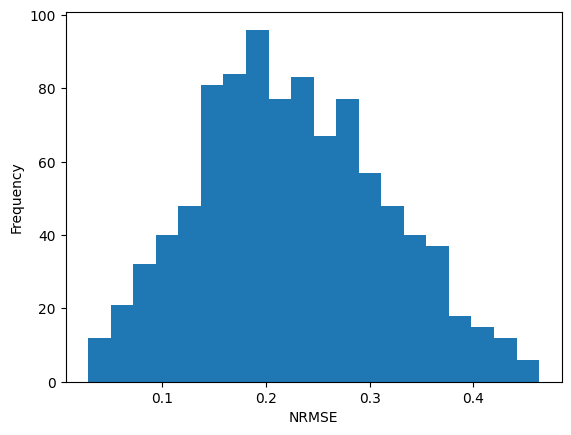

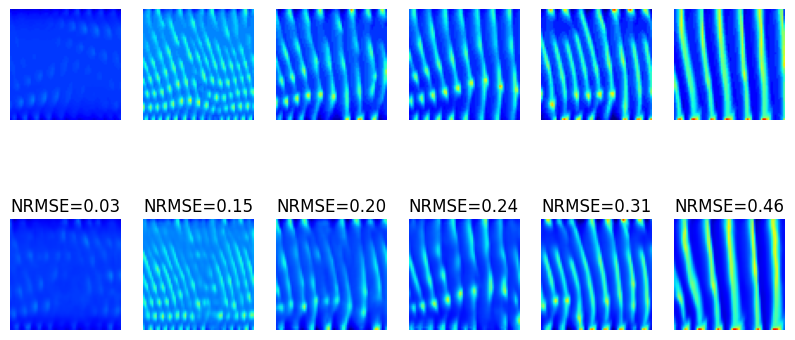

In [18]:
# %%
fid+=1
fig=plt.figure(num=fid)
ax=plt.subplot(1,1,1)
ax.hist(L2_rel_test,bins=20)
ax.set_xlabel(r'NRMSE')
ax.set_ylabel('Frequency')
print("performance on test: mean %.3e, std %.3e"%(np.mean(L2_rel_test),np.std(L2_rel_test)))
fid+=1
fig,ax=plt.subplots(2,6,num=fid,figsize=(10,5))
i,j=0,0
idx=id_test[0]
ax[i,j].imshow(out_test_rev[idx])
ax[i,j].axis('off')
i,j=1,0
ax[i,j].imshow(test_predict[idx])
ax[i,j].axis('off')
ax[i,j].set_title(r'NRMSE=%.2f'%L2_rel_test[idx])
#
j=1
idx=id_test[int(id_test.shape[0]*0.2)]

i=0
ax[i,j].imshow(out_test_rev[idx])
ax[i,j].axis('off')
i=1
ax[i,j].imshow(test_predict[idx])
ax[i,j].axis('off')
ax[i,j].set_title(r'NRMSE=%.2f'%L2_rel_test[idx])
#
j=2
idx=id_test[int(id_test.shape[0]*0.4-1)]

i=0
ax[i,j].imshow(out_test_rev[idx])
ax[i,j].axis('off')
i=1
ax[i,j].imshow(test_predict[idx])
ax[i,j].axis('off')
ax[i,j].set_title(r'NRMSE=%.2f'%L2_rel_test[idx])

#
idx=id_test[int(id_test.shape[0]*0.6-2)]
j=3

i=0
ax[i,j].imshow(out_test_rev[idx])
ax[i,j].axis('off')
i=1
ax[i,j].imshow(test_predict[idx])
ax[i,j].axis('off')
ax[i,j].set_title(r'NRMSE=%.2f'%L2_rel_test[idx])

#
idx=id_test[int(id_test.shape[0]*0.8-1)]
j=4

i=0
ax[i,j].imshow(out_test_rev[idx])
ax[i,j].axis('off')
i=1
ax[i,j].imshow(test_predict[idx])
ax[i,j].axis('off')
ax[i,j].set_title(r'NRMSE=%.2f'%L2_rel_test[idx])
#
idx=id_test[-1]
j=5
i=0
ax[i,j].imshow(out_test_rev[idx])
ax[i,j].axis('off')
i=1
ax[i,j].imshow(test_predict[idx])
ax[i,j].axis('off')
ax[i,j].set_title(r'NRMSE=%.2f'%L2_rel_test[idx])

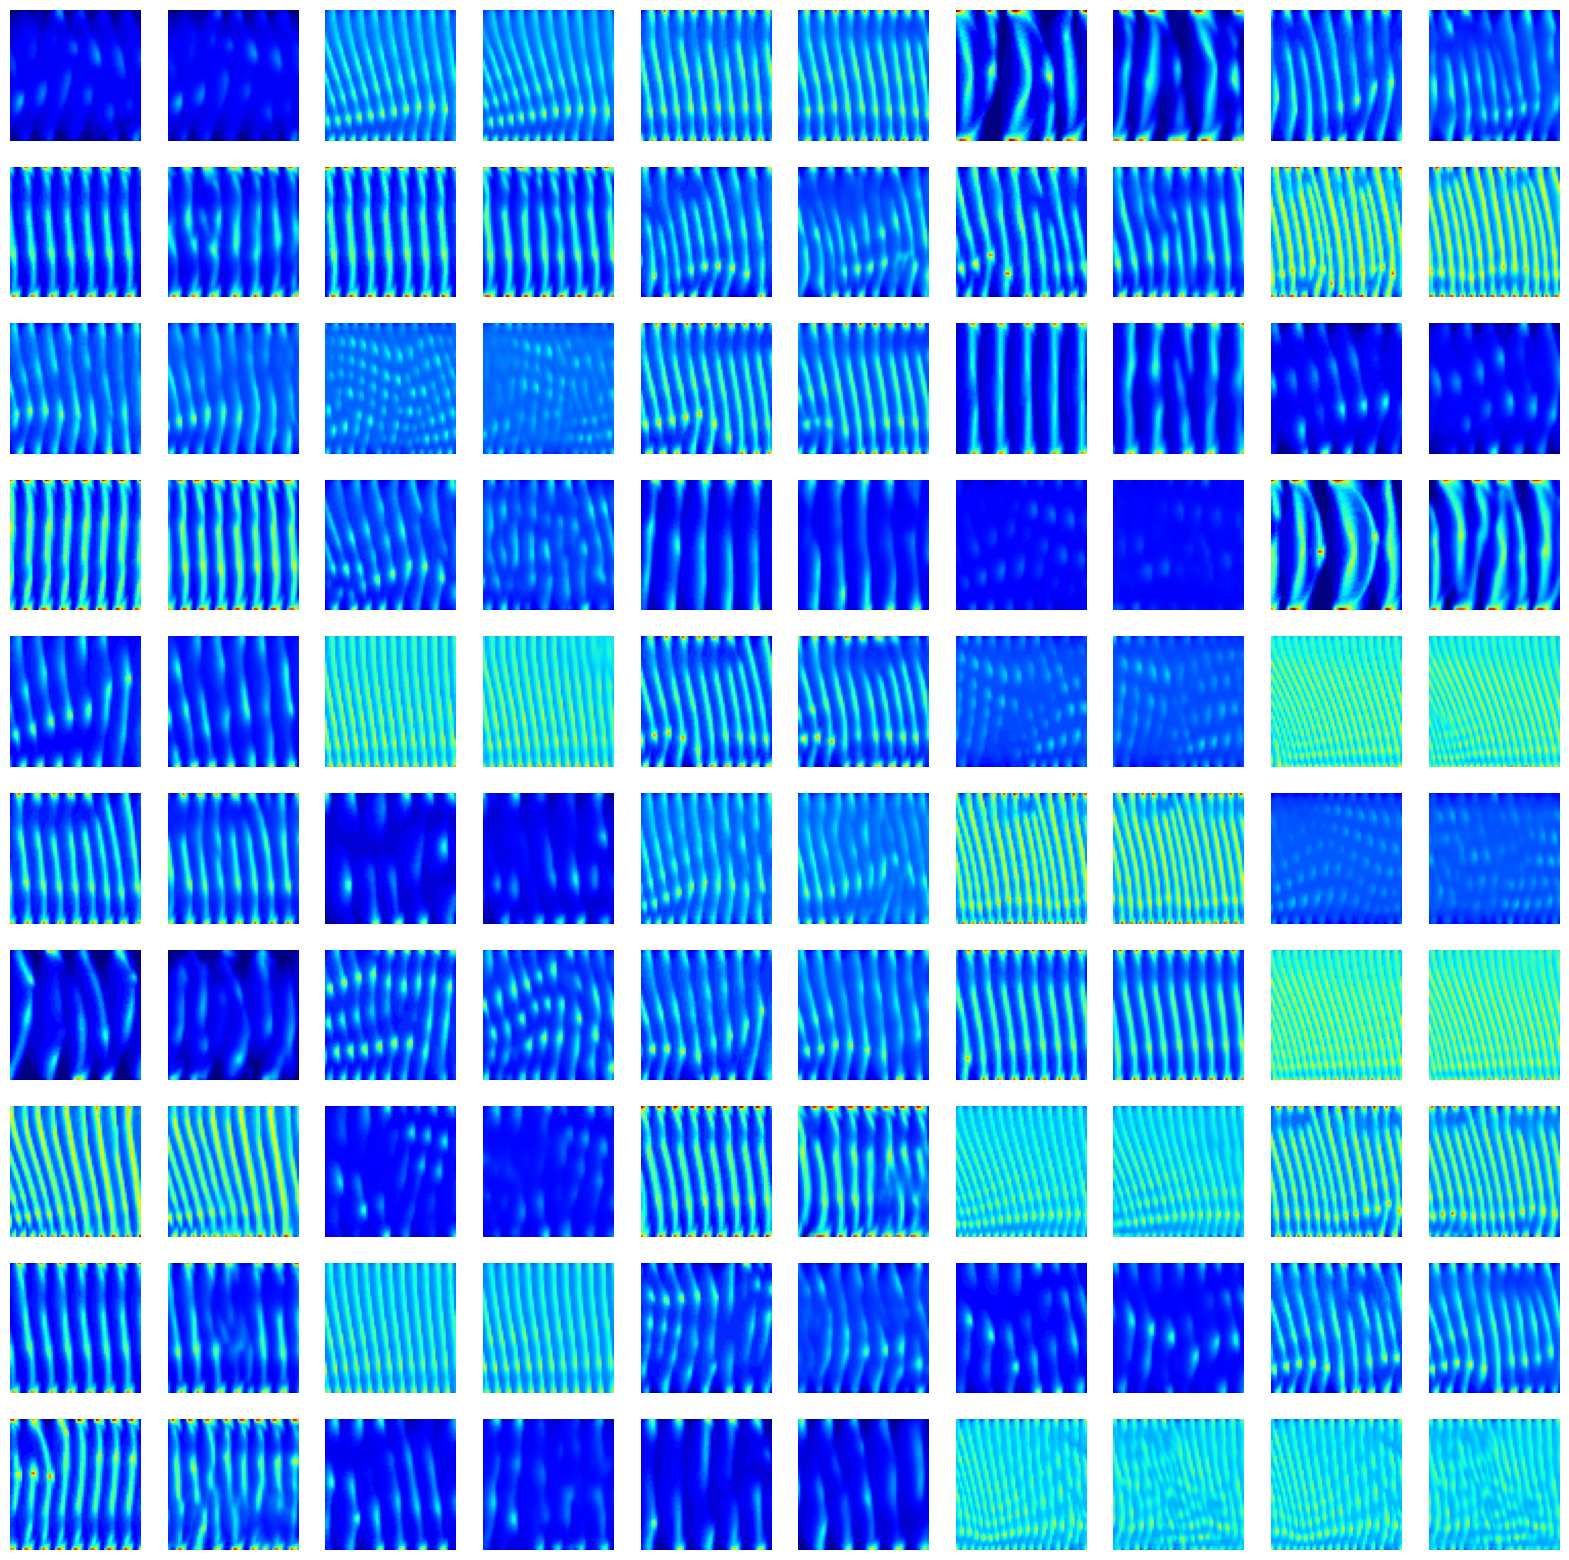

In [19]:
# %%

fid+=1
plt.close()
fig=plt.figure(num=fid,figsize=(20,20))
Ncol,Nrow=10,10
numfig=int(Ncol*Nrow/2)
np.random.seed(seed=12)
ids=np.random.randint(0,len(test_predict),numfig) 

for i, (img_t,img_p) in enumerate(zip(out_test_rev[ids],test_predict[ids])):
    ax=plt.subplot(Ncol,Nrow,2*i+1)
    ax.imshow(img_t)
    ax.axis('scaled')
    ax.axis('off')
    
    ax=plt.subplot(Ncol,Nrow,2*i+2)
    ax.imshow(img_p)
    ax.axis('scaled')
    ax.axis('off')
